In [3]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
# from lib_nn_dpe import NN_dpe
from IPython import display

import serial
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [60]:
dpe = DPE('COM3')
dpe.set_clock(50)
# dpe.shape

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [42]:
from scipy.io import loadmat
data_mat = loadmat('dataset/W_test.mat')
data_mat2 = loadmat('dataset/W60.mat')
W_test = data_mat['W_test']
W60 = data_mat2['W60']*1e-5

print(W60)



[[0.e+00 0.e+00 0.e+00 ... 1.e-05 2.e-05 6.e-05]
 [0.e+00 0.e+00 0.e+00 ... 8.e-05 5.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 0.e+00 0.e+00 5.e-05]
 ...
 [1.e-05 8.e-05 0.e+00 ... 0.e+00 0.e+00 5.e-05]
 [2.e-05 5.e-05 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [6.e-05 0.e+00 5.e-05 ... 5.e-05 0.e+00 0.e+00]]


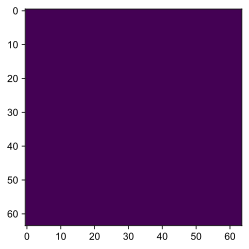

In [133]:
arr = 2
N = 64

Gtarget = np.ones((N,N)) * 1e-7
# Gtarget[:W_test.shape[0], :W_test.shape[1]] = W_test
# Gtarget[W_test.shape[0]*1:W_test.shape[0]*2, W_test.shape[1]*1:W_test.shape[1]*2 ] = W_test
# Gtarget[W_test.shape[0]*2:W_test.shape[0]*3, W_test.shape[1]*2:W_test.shape[1]*3 ] = W_test

Msel = Gtarget > 0

plt.imshow(Gtarget)

# print(W_test)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


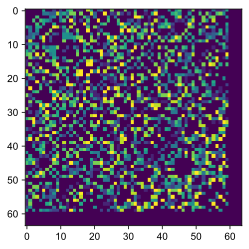

In [43]:
arr = 2
N = 64

Gtarget = np.ones((N,N)) * 0e-7
Gtarget[:W60.shape[0], :W60.shape[1]] = W60
# Gtarget[W_test.shape[0]*1:W_test.shape[0]*2, W_test.shape[1]*1:W_test.shape[1]*2 ] = W_test
# Gtarget[W_test.shape[0]*2:W_test.shape[0]*3, W_test.shape[1]*2:W_test.shape[1]*3 ] = W_test

Msel = Gtarget > 0

plt.imshow(Gtarget)

print(Gtarget)


In [57]:
data = dpe.tune_conductance(2,  Gtarget, saveHistory=True, maxSteps=600, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=1e-3,  Msel=Msel, Gtol_in=3e-6, Gtol_out=6e-6, numReads=3)

Start programming, step=599, maxBound=135 yield= 27.02% - 45.32%
913 devices to be programmed...reset 93, set 956
Setting 822 devices...
Programming with external timing Twidth=10.000 us
Resetting 93 devices...
Programming with external timing Twidth=1000.000 us


....

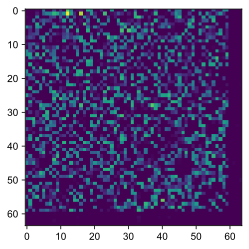

In [68]:
g = dpe.read(2, method='slow')
plt.imshow(g)
# print(g[:20,:20])



7.497851498859565e-06


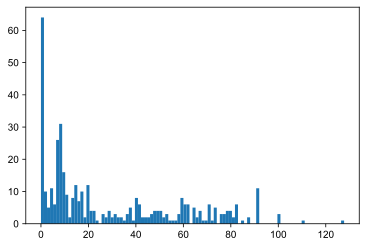

In [162]:
_ = plt.hist((g)[:20,:20].reshape(-1) * 1e6, 100)
#plt.xlim(-20, 20)

print(np.mean(np.abs((Gtarget-g)[:20,:20])))

In [13]:
save_workspace(vars(), note='zhan-prober2-programming')

Saving In(<class 'list'>), Out(<class 'dict'>), data_mat(<class 'dict'>), W_test(<class 'numpy.ndarray'>), N(<class 'int'>), Gtarget(<class 'numpy.ndarray'>), Msel(<class 'numpy.ndarray'>), data(<class 'dict'>), arr(<class 'int'>), g(<class 'numpy.ndarray'>), to 20200128-145113-zhan-prober2-programming.pkl
Saving In(<class 'list'>), W_test(<class 'numpy.ndarray'>), N(<class 'int'>), Gtarget(<class 'numpy.ndarray'>), Msel(<class 'numpy.ndarray'>), arr(<class 'int'>), g(<class 'numpy.ndarray'>), to 20200128-145113-zhan-prober2-programming.mat


In [69]:
def vec_pos_neg(vec):
    vec_pos = vec.copy()
    vec_pos[vec < 0] = 0

    vec_neg = vec.copy()
    vec_neg[vec > 0] = 0

    return vec_pos, vec_neg * (-1)


def power_iteration4(W, eigv, cycles:int, r, c1, c2):
    V = np.ones((W.shape[1],1))

    for i in range(cycles):
#         print(f'cycle={i}')
        
        v_pos, v_neg = vec_pos_neg(V)
        r_pos = dpe.multiply(2, v_pos, c_sel=[c1, c2], r_start=r)
        r_neg = dpe.multiply(2, v_neg, c_sel=[c1, c2], r_start=r)

        V_new = (eigv * V).T - (r_pos - r_neg)

        V = (V_new / np.linalg.norm(V_new)).T
#         if(i%5 == 0):
#             print(V.T)

    vec = V
    val = (vec.T @ W.T @ vec) / (vec.T @ vec)

    return val, vec

def power_iteration4_soft(W, eigv, cycles:int):
    V = np.ones((W.shape[1], 1))

    for i in range(cycles):
#         print(f'cycle = {i}')
        V_new = eigv * V - W.T @ V
        V = V_new / np.linalg.norm(V_new)
#         if(i%5 == 0):
#             print(V)

    vec = V
    val = (vec.T @ W.T @ vec) / (vec.T @ vec)

    return val, vec

def power_iteration2(W, cycles:int, r, c1, c2):
    V = np.ones((W.shape[1], 1))

    for i in range(cycles):
#         print(f'cycle={i}')
#         V_new = W @ V
        V_new = dpe.multiply(2, V, c_sel=[c1, c2], r_start=r)
        
        V = (V_new / np.linalg.norm(V_new)).T

    Eigenvector = V
    Eigenvalue = ( V.T@ W.T @ V ) / (V.T @ V)

    return Eigenvalue, Eigenvector

def power_iteration2_soft(W, cycles:int):
    V = np.ones((W.shape[1], 1))
    
    for i in range(cycles):
        V_new = W.T @ V
        V = (V_new / np.linalg.norm(V_new))
        
    Eigvec = V
    Eigv = ( V.T@ W.T @ V ) / (V.T @ V)
    
    return Eigv, Eigvec

# (eig1_soft, vec1_soft) = power_iteration2_soft(g[10:50, 10:50], 15)
# print(eig1_soft, vec1_soft)
# (eig1, vec1) = power_iteration2(g[10:50, 10:50], cycles=15, r=10, c1=10, c2=50)
# print(eig1, vec1)
# (eig2_soft, vec2_soft) = power_iteration4_soft(W60[10:50, 10:50], eig1/2, 150)
# print(eig2_soft, vec2_soft)
# (eig2, vec2) = power_iteration4(g[10:50, 10:50], eig1/2, 150, r=10, c1=10, c2=50)
# print(eig2, vec2)
# from scipy.io import savemat
# savemat('dataset/20_3.mat', {'eig2': eig2, 'eig2_soft': eig2_soft, 'vec2': vec2, 'vec2_soft': vec2_soft})
savemat('dataset/gmap.mat', {'gmap': g})

In [ ]:
eig_20 = np.zeros((1, 6))
eig_20_soft = np.zeros((1, 6))
vec_20 = np.zeros((20, 6))
vec_20_soft = np.zeros((20, 6))
n = 0
for i in range(0, 3):
    for j in range(i, 3):
        print(f'cycle = {n}')
        (eig1_soft, vec1_soft) = power_iteration2_soft(W60[i*20:(i+1)*20, j*20:(j+1)*20], 10)
        (eig1, vec1) = power_iteration2(g[i*20:(i+1)*20, j*20:(j+1)*20], cycles=10, r=i*20, c1=j*20, c2=(j+1)*20)
        (eig2_soft, vec2_soft) = power_iteration4_soft(W60[i*20:(i+1)*20, j*20:(j+1)*20], eig1, 30)
        (eig2, vec2) = power_iteration4(g[i*20:(i+1)*20, j*20:(j+1)*20], eig1, 30, r=i*20, c1=j*20, c2=(j+1)*20)
        eig_20[0, n] = eig2
        eig_20_soft[0, n] = eig2_soft
        vec_20[:, n] = vec2[:, 0]
        vec_20_soft[:, n] = vec2_soft[:, 0]
        n = n+1

                   
                

cycle = 0


In [486]:
# print(vec_20)
# print(vec_20_soft)
savemat('dataset/20_result.mat', {'gmap': g, 'eig_20': eig_20, 'eig_20_soft': eig_20_soft, 'vec_20': vec_20, 'vec_20_soft': vec_20_soft})

In [504]:
eig_40 = np.zeros((1, 3))
eig_40_soft = np.zeros((1, 3))
vec_40 = np.zeros((40, 3))
vec_40_soft = np.zeros((40, 3))
n = 0
for i in range(0, 2):
    for j in range(i, 2):
        print(f'cycle = {n}')
        (eig1_soft, vec1_soft) = power_iteration2_soft(W60[i*20:(i*20+40), j*20:(j*20+40)], 10)
        (eig1, vec1) = power_iteration2(g[i*20:(i*20+40), j*20:(j*20+40)], cycles=10, r=i*20, c1=j*20, c2=(j*20+40))
        (eig2_soft, vec2_soft) = power_iteration4_soft(W60[i*20:(i*20+40), j*20:(j*20+40)], eig1, 50)
        (eig2, vec2) = power_iteration4(g[i*20:(i*20+40), j*20:(j*20+40)], eig1, 50, r=i*20, c1=j*20, c2=(j*20+40))
        eig_40[0, n]= eig2
        eig_40_soft[0, n] = eig2_soft
        vec_40[:, n] = vec2[:, 0]
        vec_40_soft[:, n] = vec2_soft[:, 0]
        n = n+1


cycle = 0
cycle = 1
cycle = 2


In [505]:
savemat('dataset/40_result.mat', {'gmap': g, 'eig_40': eig_40, 'eig_40_soft': eig_40_soft, 'vec_40': vec_40, 'vec_40_soft': vec_40_soft})

In [499]:
(eig1_soft, vec1_soft) = power_iteration2_soft(W60[0:60, 0:60], 10)
(eig1, vec1) = power_iteration2(g[0:60, 0:60], cycles=10, r=0, c1=0, c2=60)
(eig2_soft, vec2_soft) = power_iteration4_soft(W60[0:60, 0:60], eig1, 50)
(eig2, vec2) = power_iteration4(g[0:60, 0:60], eig1, 50, r=0, c1=0, c2=60)

In [503]:
print(eig2_soft, vec2_soft)
print(eig2, vec2)
savemat('dataset/60_result.mat', {'gmap': g, 'eig_60': eig2, 'eig_60_soft': eig2_soft, 'vec_60': vec2, 'vec_60_soft': vec2_soft})

[[-0.00048365]] [[ 0.16001053]
 [-0.16398117]
 [ 0.14099869]
 [-0.04130797]
 [-0.13801927]
 [-0.08539977]
 [ 0.10332162]
 [-0.15491662]
 [ 0.2454981 ]
 [-0.06515559]
 [ 0.07037388]
 [ 0.18883765]
 [-0.0786391 ]
 [ 0.13483965]
 [-0.06126758]
 [-0.12045441]
 [ 0.14325425]
 [ 0.01924341]
 [-0.1219144 ]
 [-0.02395036]
 [ 0.13120305]
 [ 0.13634336]
 [ 0.06816825]
 [ 0.12798185]
 [-0.08785286]
 [-0.25484006]
 [-0.05394321]
 [ 0.20004454]
 [ 0.11886464]
 [-0.20203224]
 [ 0.03929955]
 [-0.15637985]
 [-0.02559662]
 [ 0.13198833]
 [-0.11644382]
 [-0.0470982 ]
 [-0.03820119]
 [ 0.10360203]
 [ 0.05207981]
 [-0.14053139]
 [ 0.07525099]
 [ 0.02057258]
 [ 0.22997279]
 [ 0.08551244]
 [-0.10257945]
 [-0.18940651]
 [ 0.13182312]
 [-0.12532753]
 [ 0.22201703]
 [-0.22935132]
 [ 0.06643334]
 [ 0.00954277]
 [ 0.04807144]
 [ 0.08660359]
 [-0.06441517]
 [-0.21195858]
 [ 0.12946462]
 [ 0.09236472]
 [-0.10249657]
 [-0.10998395]]
[[-0.00055158]] [[ 0.14006699]
 [-0.20493299]
 [ 0.21581752]
 [-0.17541681]
 [ 0.03

In [28]:
data2 = dpe.tune_conductance(arr,  Gtarget, saveHistory=True, maxSteps=500, method='fast',
                           vSetRamp=[0.5, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=10e-3,  Msel=Msel, Gtol_in=4e-6, Gtol_out=10e-6, numReads=3)

Start programming, step=375, maxBound=49 yield= 80.12% - 94.12%
1 devices to be programmed...reset 4, set 46
Setting 0 devices...
Programming with external timing Twidth=10.000 us
Resetting 2 devices...
Programming with external timing Twidth=10000.000 us
------------------------------
Programming completed.


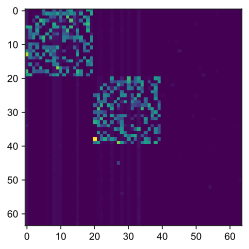

In [32]:
plt.imshow(dpe.read(2, method='fast'))

In [188]:
from scipy.io import savemat

savemat('dataset/W60_exp.mat', {'W60_exp': g})

In [426]:
v0 = np.ones((10,1))*0.2
v1 = g[:10, :10].T @ v0
v2 = dpe.multiply(0, v0, c_sel=[0, 10])

In [427]:
print(v1.T)
print(v2)
# print(np.array([v0]))

[[0.00000000e+00 2.93776474e-05 5.16959922e-06 8.37080482e-05
  1.00244379e-05 1.48005865e-05 7.52688172e-06 1.65659824e-05
  6.85288368e-06 1.76129032e-05]]
[[1.39535775e-08 2.91951776e-05 5.24869185e-06 8.65591398e-05
  1.72702356e-05 1.62326618e-05 1.58014203e-05 1.12799245e-05
  1.89178311e-05 1.69525904e-05]]


In [279]:
error = np.zeros((1, 60))
v1 = np.zeros((1, 60))
v2 = np.zeros((1, 60))
for i in range(0, 1):
    v0 = np.random.rand(60, 1)
    for j in range(0, 60):
        print(f'cycle = {j}')
        v1[0, j] = g[:60, j] @ v0
        v2[0, j] = dpe.multiply(arr, v0, c_sel=[j, j+1])
#         error[i, j] = (v1-v2)
    
    
    

cycle = 0
cycle = 1
cycle = 2
cycle = 3
cycle = 4
cycle = 5
cycle = 6
cycle = 7
cycle = 8
cycle = 9
cycle = 10
cycle = 11
cycle = 12
cycle = 13
cycle = 14
cycle = 15
cycle = 16
cycle = 17
cycle = 18
cycle = 19
cycle = 20
cycle = 21
cycle = 22
cycle = 23
cycle = 24
cycle = 25
cycle = 26
cycle = 27
cycle = 28
cycle = 29
cycle = 30
cycle = 31
cycle = 32
cycle = 33
cycle = 34
cycle = 35
cycle = 36
cycle = 37
cycle = 38
cycle = 39
cycle = 40
cycle = 41
cycle = 42
cycle = 43
cycle = 44
cycle = 45
cycle = 46
cycle = 47
cycle = 48
cycle = 49
cycle = 50
cycle = 51
cycle = 52
cycle = 53
cycle = 54
cycle = 55
cycle = 56
cycle = 57
cycle = 58
cycle = 59


In [264]:
print(error)
error = np.array(error)
# np.histogram(error)

[[ 0.46374754 -0.13915558  0.2138206  -0.9027935   0.21718289 -0.14484991
   0.27458313 -0.06675469  0.4159025   0.32012802  0.38314952 -0.59544698
   0.06968316  0.214663    0.2195115   0.40316551 -0.36121291  0.13870694
  -0.23494107  0.06762758 -0.27635654  0.20286296  0.22743513 -0.00779975
   0.17355793  0.30742206 -0.52589461  0.02225328  0.17396465  0.12703907
   0.25048249 -0.10784132 -0.37935911  0.44980973 -1.12907588 -0.04678064
   0.03702862 -0.29501288  0.00382796 -0.1240741  -0.4192727   0.21048287
   0.37586368 -0.1893327   0.25796383  0.21880006 -0.36565612 -0.76850838
  -0.02771572 -0.21288393 -0.35788268  0.31307168  0.23760777  0.08233943
   0.17610642  0.5632188  -0.04400754 -0.87062796  0.34657668 -0.56667546]]


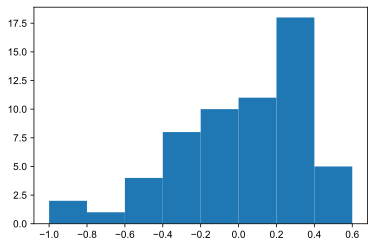

In [266]:

plt.hist(error.T, bins=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
plt.show()

[[0.00090819 0.0007529  0.00084699 0.00059146 0.00091956 0.00087604
  0.00079764 0.00065781 0.00131755 0.00125333 0.00066366 0.00067416
  0.0008056  0.00084973 0.00098923 0.0010478  0.00073144 0.00070958
  0.00069769 0.00092679 0.00048954 0.00076706 0.00087203 0.00054506
  0.0007706  0.00097634 0.00066021 0.00081806 0.00117372 0.0009228
  0.00063338 0.00083882 0.00069737 0.00092379 0.00045234 0.00073068
  0.00058766 0.00075829 0.00087923 0.00059132 0.00054275 0.00085784
  0.00113915 0.00061734 0.0008394  0.00110334 0.0004741  0.00068463
  0.00080846 0.00095583 0.00045922 0.00096477 0.00080688 0.00073899
  0.00078929 0.00103679 0.00057092 0.00055034 0.0009992  0.00043836]
 [0.00042993 0.0008823  0.00069274 0.00107824 0.00073933 0.00098453
  0.00056686 0.00071236 0.00077115 0.00079328 0.00036671 0.00106843
  0.00071695 0.00062104 0.00080128 0.00059361 0.00096556 0.00069722
  0.00084618 0.00083732 0.00063322 0.00060877 0.00069247 0.00058576
  0.00061906 0.00064669 0.00102092 0.00076725 0.

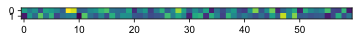

In [285]:
v_test = np.append(v1, v2, axis = 0)

print(v_test)
plt.imshow(v_test)

In [280]:
print(v1)
print(v2)

[[0.00090819 0.0007529  0.00084699 0.00059146 0.00091956 0.00087604
  0.00079764 0.00065781 0.00131755 0.00125333 0.00066366 0.00067416
  0.0008056  0.00084973 0.00098923 0.0010478  0.00073144 0.00070958
  0.00069769 0.00092679 0.00048954 0.00076706 0.00087203 0.00054506
  0.0007706  0.00097634 0.00066021 0.00081806 0.00117372 0.0009228
  0.00063338 0.00083882 0.00069737 0.00092379 0.00045234 0.00073068
  0.00058766 0.00075829 0.00087923 0.00059132 0.00054275 0.00085784
  0.00113915 0.00061734 0.0008394  0.00110334 0.0004741  0.00068463
  0.00080846 0.00095583 0.00045922 0.00096477 0.00080688 0.00073899
  0.00078929 0.00103679 0.00057092 0.00055034 0.0009992  0.00043836]]
[[0.00042993 0.0008823  0.00069274 0.00107824 0.00073933 0.00098453
  0.00056686 0.00071236 0.00077115 0.00079328 0.00036671 0.00106843
  0.00071695 0.00062104 0.00080128 0.00059361 0.00096556 0.00069722
  0.00084618 0.00083732 0.00063322 0.00060877 0.00069247 0.00058576
  0.00061906 0.00064669 0.00102092 0.00076725 0

....

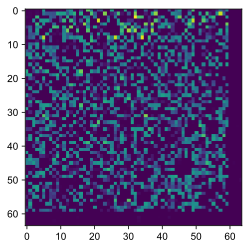

In [407]:
g = dpe.read(2, method='slow')
plt.imshow(g)

In [402]:
vec = np.random.random((10, 100))

vec_exp = dpe.multiply(2, vec, c_sel = [0,16], Tdly=500)

In [403]:
vec_soft = vec.T @ g[:10, :16]

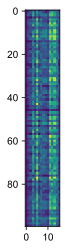

In [404]:
plt.imshow(vec_exp)

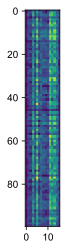

In [405]:
plt.imshow(vec_soft)

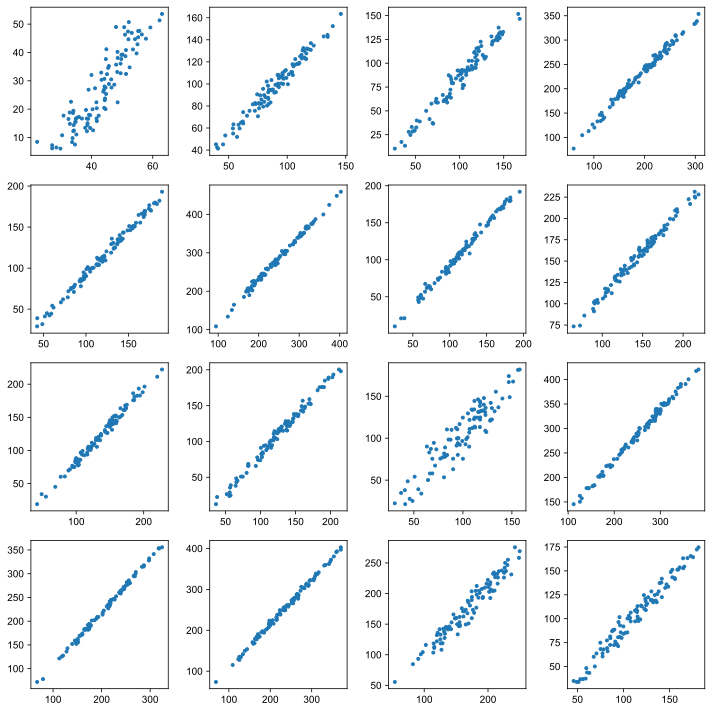

In [406]:
plt.figure(figsize=(10,10))

for c in range(16):
    plt.subplot(4,4, c+1)
    plt.plot( vec_exp[:,c] * 1e6, vec_soft[:,c]*1e6, '.')
    
plt.tight_layout()

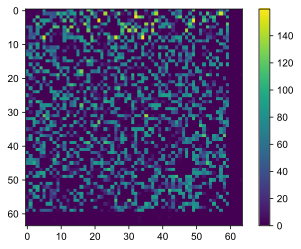

In [387]:
plt.imshow(g*1e6)
plt.colorbar()